In [1]:
!mkdir -p ~/aiffel/transformer_chatbot/data
!ln -s ~/data/* ~/aiffel/transformer_chatbot/data

ln: failed to create symbolic link '/aiffel/aiffel/transformer_chatbot/data/ChatbotData.csv': File exists
ln: failed to create symbolic link '/aiffel/aiffel/transformer_chatbot/data/ko.bin': File exists
ln: failed to create symbolic link '/aiffel/aiffel/transformer_chatbot/data/word2vec_ko.model': File exists
ln: failed to create symbolic link '/aiffel/aiffel/transformer_chatbot/data/word2vec_ko.model.trainables.syn1neg.npy': File exists
ln: failed to create symbolic link '/aiffel/aiffel/transformer_chatbot/data/word2vec_ko.model.wv.vectors.npy': File exists


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


In [3]:
!pip install --upgrade gensim==3.8.0
from gensim.models.word2vec import Word2Vec
w2v_path = os.getenv('HOME')+'/aiffel/이지수/GDNLP/12. 번역가는 대화에도 능하다/ko.bin'
w2v_model = Word2Vec.load(w2v_path)

     |████████████████████████████████| 23.4 MB 6.9 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.0-cp39-cp39-linux_x86_64.whl size=23983933 sha256=eac9b5ba8d6b91d260e6d740c46a49e614b12dcb9c493062ba725d0f3772d5af
  Stored in directory: /aiffel/.cache/pip/wheels/fb/18/fa/2a0084905c1be0cead09a515d05015c1f939afb16fd7893ff4
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2


In [4]:
zip_path = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

print('슝=3')

2654208/2638744 [==============================] - 0s 0us/step
슝=3


In [5]:
file_path = os.path.dirname(zip_path)+"/spa-eng/spa.txt"

with open(file_path, "r") as f:
    spa_eng_sentences = f.read().splitlines()

spa_eng_sentences = list(set(spa_eng_sentences)) 
total_sentence_count = len(spa_eng_sentences)
print("Example:", total_sentence_count)

for sen in spa_eng_sentences[0:100][::20]: 
    print(">>", sen)

Example: 118964
>> I am not going out because I have to clean the house.	No voy a salir porque tengo que limpiar la casa.
>> I want to compete.	Quiero competir.
>> You don't have to stay to the end.	No tienes que quedarte hasta el final.
>> Please help Tom.	Ayuda a Tom, por favor.
>> I wasn't frightened.	No tenía miedo.


In [6]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

print("슝=3")

슝=3


In [7]:
spa_eng_sentences = list(map(preprocess_sentence, spa_eng_sentences))

print('슝=3')

슝=3


In [8]:
test_sentence_count = total_sentence_count // 200
print("Test Size: ", test_sentence_count)
print("\n")

train_spa_eng_sentences = spa_eng_sentences[:-test_sentence_count]
test_spa_eng_sentences = spa_eng_sentences[-test_sentence_count:]
print("Train Example:", len(train_spa_eng_sentences))
for sen in train_spa_eng_sentences[0:100][::20]: 
    print(">>", sen)
print("\n")
print("Test Example:", len(test_spa_eng_sentences))
for sen in test_spa_eng_sentences[0:100][::20]: 
    print(">>", sen)

Test Size:  594


Train Example: 118370
>> i am not going out because i have to clean the house.	no voy a salir porque tengo que limpiar la casa.
>> i want to compete.	quiero competir.
>> you don't have to stay to the end.	no tienes que quedarte hasta el final.
>> please help tom.	ayuda a tom, por favor.
>> i wasn't frightened.	no tenía miedo.


Test Example: 594
>> i think we're going to stay for another day.	creo que nos quedaremos otro día más.
>> you drank too much.	tomaron demasiado.
>> i often play soccer after class.	a menudo suelo jugar fútbol después de clases.
>> what a pity!	qué pena.
>> they own a lot of land.	ellos poseen muchas tierras.


In [9]:
def split_spa_eng_sentences(spa_eng_sentences):
    spa_sentences = []
    eng_sentences = []
    for spa_eng_sentence in tqdm(spa_eng_sentences):
        eng_sentence, spa_sentence = spa_eng_sentence.split('\t')
        spa_sentences.append(spa_sentence)
        eng_sentences.append(eng_sentence)
    return eng_sentences, spa_sentences

print('슝=3')

슝=3


In [10]:
train_eng_sentences, train_spa_sentences = split_spa_eng_sentences(train_spa_eng_sentences)
print(len(train_eng_sentences))
print(train_eng_sentences[0])
print('\n')
print(len(train_spa_sentences))
print(train_spa_sentences[0])

  0%|          | 0/118370 [00:00<?, ?it/s]

118370
i am not going out because i have to clean the house.


118370
no voy a salir porque tengo que limpiar la casa.


In [11]:
test_eng_sentences, test_spa_sentences = split_spa_eng_sentences(test_spa_eng_sentences)
print(len(test_eng_sentences))
print(test_eng_sentences[0])
print('\n')
print(len(test_spa_sentences))
print(test_spa_sentences[0])

  0%|          | 0/594 [00:00<?, ?it/s]

594
i think we're going to stay for another day.


594
creo que nos quedaremos otro día más.


In [12]:
def generate_tokenizer(corpus,
                       vocab_size,
                       lang="spa-eng",
                       pad_id=0,   # pad token의 일련번호
                       bos_id=1,  # 문장의 시작을 의미하는 bos token(<s>)의 일련번호
                       eos_id=2,  # 문장의 끝을 의미하는 eos token(</s>)의 일련번호
                       unk_id=3):   # unk token의 일련번호
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus: f.write(str(row) + '\n')

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer

print("슝=3")

슝=3


In [13]:
VOCAB_SIZE = 20000
tokenizer = generate_tokenizer(train_eng_sentences + train_spa_sentences, VOCAB_SIZE, 'spa-eng')
tokenizer.set_encode_extra_options("bos:eos")  # 문장 양 끝에 <s> , </s> 추가

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=././spa-eng_corpus.txt --model_prefix=spa-eng_spm --vocab_size=20000--pad_id==0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ././spa-eng_corpus.txt
  input_format: 
  model_prefix: spa-eng_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: -1

True

) Done! preprocessed 236740 sentences.
unigram_model_trainer.cc(139) LOG(INFO) Making suffix array...
unigram_model_trainer.cc(143) LOG(INFO) Extracting frequent sub strings...
unigram_model_trainer.cc(194) LOG(INFO) Initialized 110152 seed sentencepieces
trainer_interface.cc(526) LOG(INFO) Tokenizing input sentences with whitespace: 236740
trainer_interface.cc(537) LOG(INFO) Done! 62407
unigram_model_trainer.cc(489) LOG(INFO) Using 62407 sentences for EM training
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=35523 obj=10.7522 num_tokens=118500 num_tokens/piece=3.33587
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=28162 obj=8.52333 num_tokens=118969 num_tokens/piece=4.22445
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=21998 obj=8.47802 num_tokens=125725 num_tokens/piece=5.71529
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=21984 obj=8.46392 num_tokens=125783 num_tokens/piece=5.72157
trainer_interface.cc(615) LOG(INFO) Saving model: s

In [14]:
def make_corpus(sentences, tokenizer):
    corpus = []
    for sentence in tqdm(sentences):
        tokens = tokenizer.encode_as_ids(sentence)
        corpus.append(tokens)
    return corpus

print('슝=3')

슝=3


In [15]:
eng_corpus = make_corpus(train_eng_sentences, tokenizer)
spa_corpus = make_corpus(train_spa_sentences, tokenizer)

  0%|          | 0/118370 [00:00<?, ?it/s]

  0%|          | 0/118370 [00:00<?, ?it/s]

In [16]:
print(train_eng_sentences[0])
print(eng_corpus[0])
print('\n')
print(train_spa_sentences[0])
print(spa_corpus[0])

i am not going out because i have to clean the house.
[1, 6, 198, 70, 142, 120, 56, 498, 6, 40, 10, 1097, 9, 226, 0, 2]


no voy a salir porque tengo que limpiar la casa.
[1, 14, 255, 4, 597, 43, 504, 115, 15, 2115, 16, 117, 0, 2]


In [17]:
MAX_LEN = 50
enc_ndarray = tf.keras.preprocessing.sequence.pad_sequences(eng_corpus, maxlen=MAX_LEN, padding='post')
dec_ndarray = tf.keras.preprocessing.sequence.pad_sequences(spa_corpus, maxlen=MAX_LEN, padding='post')

print('슝=3')

슝=3


In [18]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_ndarray, dec_ndarray)).batch(batch_size=BATCH_SIZE)

print('슝=3')

슝=3


In [19]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

    return sinusoid_table
print("슝=3")

슝=3


In [20]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [22]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out
print("슝=3")

슝=3


In [23]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [24]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [27]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [28]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
		
d_model = 512

In [29]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [30]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [31]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [32]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [33]:
EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()

  0%|          | 0/1850 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

In [34]:
# 아래 두 문장을 바꿔가며 테스트 해보세요
reference = "많 은 자연어 처리 연구자 들 이 트랜스포머 를 선호 한다".split()
candidate = "적 은 자연어 학 개발자 들 가 트랜스포머 을 선호 한다 요".split()

print("원문:", reference)
print("번역문:", candidate)
print("BLEU Score:", sentence_bleu([reference], candidate))

원문: ['많', '은', '자연어', '처리', '연구자', '들', '이', '트랜스포머', '를', '선호', '한다']
번역문: ['적', '은', '자연어', '학', '개발자', '들', '가', '트랜스포머', '을', '선호', '한다', '요']
BLEU Score: 8.190757052088229e-155


/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [35]:
print("1-gram:", sentence_bleu([reference], candidate, weights=[1, 0, 0, 0]))
print("2-gram:", sentence_bleu([reference], candidate, weights=[0, 1, 0, 0]))
print("3-gram:", sentence_bleu([reference], candidate, weights=[0, 0, 1, 0]))
print("4-gram:", sentence_bleu([reference], candidate, weights=[0, 0, 0, 1]))

1-gram: 0.5
2-gram: 0.18181818181818182
3-gram: 2.2250738585072626e-308
4-gram: 2.2250738585072626e-308


In [36]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

print("BLEU-1:", calculate_bleu(reference, candidate, weights=[1, 0, 0, 0]))
print("BLEU-2:", calculate_bleu(reference, candidate, weights=[0, 1, 0, 0]))
print("BLEU-3:", calculate_bleu(reference, candidate, weights=[0, 0, 1, 0]))
print("BLEU-4:", calculate_bleu(reference, candidate, weights=[0, 0, 0, 1]))

print("\nBLEU-Total:", calculate_bleu(reference, candidate))

BLEU-1: 0.5
BLEU-2: 0.18181818181818182
BLEU-3: 0.010000000000000004
BLEU-4: 0.011111111111111112

BLEU-Total: 0.05637560315259291


In [37]:
def translate(tokens, model, src_tokenizer, tgt_tokenizer):
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)   
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)  
    return result

print("슝=3")

슝=3


In [38]:
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    src_tokens = src_tokenizer.encode_as_ids(src_sentence)
    tgt_tokens = tgt_tokenizer.encode_as_ids(tgt_sentence)

    if (len(src_tokens) > MAX_LEN): return None
    if (len(tgt_tokens) > MAX_LEN): return None

    reference = tgt_sentence.split()
    candidate = translate(src_tokens, model, src_tokenizer, tgt_tokenizer).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score
        
print('슝=3')

슝=3


In [39]:
# 인덱스를 바꿔가며 테스트해 보세요
test_idx = 0

eval_bleu_single(transformer, 
                 test_eng_sentences[test_idx], 
                 test_spa_sentences[test_idx], 
                 tokenizer, 
                 tokenizer)

Source Sentence:  i think we're going to stay for another day.
Model Prediction:  ['creo', 'que', 'vamos', 'a', 'quedarme', 'un', 'día', 'para', 'otro', 'día', 'el', 'día', 'otro', 'día', 'de', 'otro', 'día', 'nadie', 'el', 'día']
Real:  ['creo', 'que', 'nos', 'quedaremos', 'otro', 'día', 'más.']
Score: 0.028800



0.028800248893410603

In [40]:
def eval_bleu(model, src_sentences, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], src_tokenizer, tgt_tokenizer, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)
    
print("슝=3")

슝=3


In [41]:
eval_bleu(transformer, test_eng_sentences, test_spa_sentences, tokenizer, tokenizer, verbose=False)

  0%|          | 0/594 [00:00<?, ?it/s]

Num of Sample: 594
Total Score: 0.0928238216325237


In [42]:
def beam_search_decoder(prob, beam_size):
    sequences = [[[], 1.0]]  # 생성된 문장과 점수를 저장

    for tok in prob:
        all_candidates = []

        for seq, score in sequences:
            for idx, p in enumerate(tok): # 각 단어의 확률을 총점에 누적 곱
                candidate = [seq + [idx], score * -math.log(-(p-1))]
                all_candidates.append(candidate)

        ordered = sorted(all_candidates,
                         key=lambda tup:tup[1],
                         reverse=True) # 총점 순 정렬
        sequences = ordered[:beam_size] # Beam Size에 해당하는 문장만 저장 

    return sequences

print("슝=3")

슝=3


In [43]:
vocab = {
    0: "<pad>",
    1: "까요?",
    2: "커피",
    3: "마셔",
    4: "가져",
    5: "될",
    6: "를",
    7: "한",
    8: "잔",
    9: "도",
}

prob_seq = [[0.01, 0.01, 0.60, 0.32, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.75, 0.01, 0.01, 0.17],
            [0.01, 0.01, 0.01, 0.35, 0.48, 0.10, 0.01, 0.01, 0.01, 0.01],
            [0.24, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.68],
            [0.01, 0.01, 0.12, 0.01, 0.01, 0.80, 0.01, 0.01, 0.01, 0.01],
            [0.01, 0.81, 0.01, 0.01, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01],
            [0.70, 0.22, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]

prob_seq = np.array(prob_seq)
beam_size = 3

result = beam_search_decoder(prob_seq, beam_size)

for seq, score in result:
    sentence = ""

    for word in seq:
        sentence += vocab[word] + " "

    print(sentence, "// Score: %.4f" % score)

커피 를 가져 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 42.5243
커피 를 마셔 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 28.0135
마셔 를 가져 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 17.8983


In [44]:
# calc_prob() 구현
def calc_prob(src_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = \
    generate_masks(src_ids, tgt_ids)

    predictions, enc_attns, dec_attns, dec_enc_attns =\
    model(src_ids, 
            tgt_ids,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask)
    
    return tf.math.softmax(predictions, axis=-1)
print("슝=3")

슝=3


In [45]:
def beam_search_decoder(sentence, 
                        src_len,
                        tgt_len,
                        model,
                        src_tokenizer,
                        tgt_tokenizer,
                        beam_size):
    tokens = src_tokenizer.encode_as_ids(sentence)
    
    src_in = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                            maxlen=src_len,
                                                            padding='post')

    pred_cache = np.zeros((beam_size * beam_size, tgt_len), dtype=np.int64)
    pred_tmp = np.zeros((beam_size, tgt_len), dtype=np.int64)

    eos_flag = np.zeros((beam_size, ), dtype=np.int64)
    scores = np.ones((beam_size, ))

    pred_tmp[:, 0] = tgt_tokenizer.bos_id()

    dec_in = tf.expand_dims(pred_tmp[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

    for seq_pos in range(1, tgt_len):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred_tmp[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred_tmp[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

            if prediction[-1] == tgt_tokenizer.eos_id():
                eos_flag[beam_idx] = -1

    pred = []
    for long_pred in pred_tmp:
        zero_idx = long_pred.tolist().index(tgt_tokenizer.eos_id())
        short_pred = long_pred[:zero_idx+1]
        pred.append(short_pred)
    return pred

In [46]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                            candidate,
                            weights=weights,
                            smoothing_function=SmoothingFunction().method1)

print('슝=3')

슝=3


In [47]:
def beam_bleu(reference, ids, tokenizer):
    reference = reference.split()

    total_score = 0.0
    for _id in ids:
        candidate = tokenizer.decode_ids(_id.tolist()).split()
        score = calculate_bleu(reference, candidate)

        print("Reference:", reference)
        print("Candidate:", candidate)
        print("BLEU:", calculate_bleu(reference, candidate))

        total_score += score
        
    return total_score / len(ids)

In [48]:
# 인덱스를 바꿔가며 확인해 보세요
test_idx = 1

ids = \
beam_search_decoder(test_eng_sentences[test_idx],
                    MAX_LEN,
                    MAX_LEN,
                    transformer,
                    tokenizer,
                    tokenizer,
                    beam_size=5)

bleu = beam_bleu(test_spa_sentences[test_idx], ids, tokenizer)
print(bleu)

Reference: ['yo', 'lo', 'conozco', 'de', 'hace', 'diez', 'años.']
Candidate: ['lo', 'he', 'conocido', 'por', 'diez', 'años', 'desde', 'hace', 'diez', 'años', 'de', 'diez', 'años']
BLEU: 0.039073802494525016
Reference: ['yo', 'lo', 'conozco', 'de', 'hace', 'diez', 'años.']
Candidate: ['lo', 'he', 'conocido', 'por', 'diez', 'años', 'desde', 'hace', 'diez', 'años', 'menos', 'diez', 'años']
BLEU: 0.036362270465000714
Reference: ['yo', 'lo', 'conozco', 'de', 'hace', 'diez', 'años.']
Candidate: ['hace', 'he', 'conocido', 'por', 'diez', 'años', 'desde', 'hace', 'diez', 'años', 'de', 'diez', 'años']
BLEU: 0.036362270465000714
Reference: ['yo', 'lo', 'conozco', 'de', 'hace', 'diez', 'años.']
Candidate: ['hace', 'he', 'conocido', 'por', 'diez', 'años', 'desde', 'hace', 'diez', 'años', 'menos', 'diez', 'años']
BLEU: 0.03285702044797773
Reference: ['yo', 'lo', 'conozco', 'de', 'hace', 'diez', 'años.']
Candidate: ['lo', 'he', 'conocido', 'por', 'diez', 'años', 'desde', 'hace', 'diez', 'años', 'a', 

In [49]:
import gensim.downloader as api

wv = api.load('glove-wiki-gigaword-300')

[=================================================-] 98.2% 369.3/376.1MB downloaded


In [50]:
wv.most_similar("banana")

[('bananas', 0.6691170930862427),
 ('mango', 0.580410361289978),
 ('pineapple', 0.5492371916770935),
 ('coconut', 0.5462779402732849),
 ('papaya', 0.541056752204895),
 ('fruit', 0.5218108296394348),
 ('growers', 0.4877638816833496),
 ('nut', 0.4839959144592285),
 ('peanut', 0.48062020540237427),
 ('potato', 0.4806118607521057)]

In [51]:
sample_sentence = "you know ? all you need is attention ."
sample_tokens = sample_sentence.split()

selected_tok = random.choice(sample_tokens)

result = ""
for tok in sample_tokens:
    if tok is selected_tok:
        result += wv.most_similar(tok)[0][0] + " "

    else:
        result += tok + " "

print("From:", sample_sentence)
print("To:", result)

From: you know ? all you need is attention .
To: you know ? all you need is focus . 


In [52]:
def lexical_sub(sentence, word2vec):
    res = ""
    toks = sentence.split()

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [53]:
new_corpus = []

for old_src in tqdm(test_eng_sentences):
    new_src = lexical_sub(old_src, wv)
    if new_src is not None: 
        new_corpus.append(new_src)
    # Augmentation이 없더라도 원본 문장을 포함시킵니다
    new_corpus.append(old_src)

print(new_corpus[:10])

  0%|          | 0/594 [00:00<?, ?it/s]

["i really we're going to stay for another day. ", "i think we're going to stay for another day.", 'i’ve commonly him for ten years. ', 'i’ve known him for ten years.', 'he has the least money of u.s. all. ', 'he has the least money of us all.', "let's cut across it field. ", "let's cut across this field.", 'language can be used where many ways. ', 'language can be used in many ways.']


# 12-7. Project: 멋진 챗봇 만들기

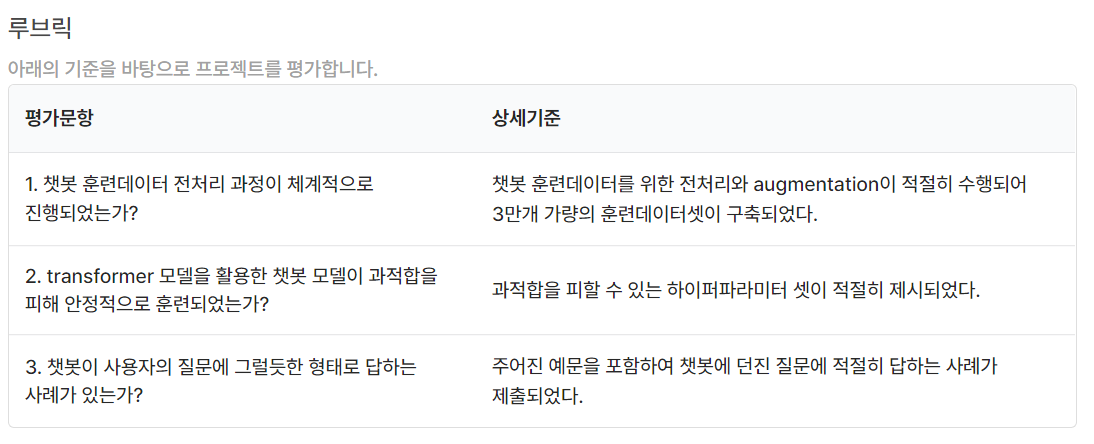

In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import gensim

import re
import os
import random
     

In [55]:
%%capture
!pip install sentencepiece
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [56]:
data = pd.read_csv('/aiffel/aiffel/Chatbot_data/ChatbotData.csv')

In [57]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [58]:
src = []
tgt = []
for s, t in zip(data['Q'], data['A']):
    src.append(str(s))
    tgt.append(str(t))

In [59]:
print('Q: ', src[0], '\n','Q 총 길이: ', len(src))
print('A: ', tgt[0], '\n','A 총 길이: ', len(tgt))

Q:  12시 땡! 
 Q 총 길이:  11823
A:  하루가 또 가네요. 
 A 총 길이:  11823


In [60]:
for i in range(10):
    print('Q :', data['Q'][i])
    print('A :', data['A'][i])    
    print()

Q : 12시 땡!
A : 하루가 또 가네요.

Q : 1지망 학교 떨어졌어
A : 위로해 드립니다.

Q : 3박4일 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : 3박4일 정도 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : PPL 심하네
A : 눈살이 찌푸려지죠.

Q : SD카드 망가졌어
A : 다시 새로 사는 게 마음 편해요.

Q : SD카드 안돼
A : 다시 새로 사는 게 마음 편해요.

Q : SNS 맞팔 왜 안하지ㅠㅠ
A : 잘 모르고 있을 수도 있어요.

Q : SNS 시간낭비인 거 아는데 매일 하는 중
A : 시간을 정하고 해보세요.

Q : SNS 시간낭비인데 자꾸 보게됨
A : 시간을 정하고 해보세요.



In [61]:
data[data.duplicated(['Q'])]

,Q,A,label
196,고양이 키우고 싶어,가족들과 상의해보세요.,0
235,공시 준비 힘들어,잘 될 거예요.,0
1294,돈 벌고 싶어,많이 벌수록 좋아요.,0
1445,로또 번호 알려줘,알면 제가 하죠.,0
1481,마음이 울적해,거리를 걸어보세요.,0
...,...,...,...
11642,착해서 잘해주는 건지 좋아하는 건지,헷갈린다고 말해보세요.,2
11649,첫 눈에 반하는게 가능해?,당연히 가능하죠.,2
11658,첫사랑 생각나,지금의 사랑에 충실하세요.,2
11732,커플여행이 나을까 그냥 우리끼리 갈까?,저는 둘이 가는 게 좋아요.,2


In [62]:
data[data['Q']==data['Q'][11819]]

,Q,A,label
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2


In [63]:
data[data.duplicated(['A'])]

,Q,A,label
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0
12,가끔 뭐하는지 궁금해,그 사람도 그럴 거예요.,0
18,가스불 켜놓고 나온거 같아,빨리 집에 돌아가서 끄고 나오세요.,0
...,...,...,...
11806,혼자만 설레고 혼자서 끝내는 짝사랑 그만할래.,맘고생 많았어요.,2
11807,화이트데이에 고백할까요?,선물을 주면서 솔직하고 당당하게 고백해보세요.,2
11809,확실히 날 좋아하는 걸 아는 남자랑 친구가 될 수 있을까?,그 사람을 위해서는 그러면 안돼요.,2
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.,2


In [64]:
data[data['A']==data['A'][3]]

,Q,A,label
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0


In [65]:
data[data['A']==data['A'][6]]

,Q,A,label
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0


In [66]:
data[data['A']==data['A'][566]]

,Q,A,label
566,나 친구들한테 인정받고 싶어,지금도 인정받고 있어요.,0
4647,친구들한테 인정받을 수 있을까,지금도 인정받고 있어요.,0


In [67]:
data.drop_duplicates(['A'], inplace=True)
len(data)

7779

In [68]:
data.drop_duplicates(['Q'], inplace=True)
len(data)

7727

In [69]:
print('total data length :', len(data))

total data length : 7727


In [70]:
questions = data['Q']
answers = data['A']

In [71]:
print('questions의 샘플 수 : ', len(questions))
print('answers의 샘플 수 : ', len(answers))


questions의 샘플 수 :  7727
answers의 샘플 수 :  7727


In [72]:
data_zip = zip(questions, answers)
data_zip

In [73]:
set_data = set(data_zip)

In [74]:
len(set_data)

7727

In [75]:
questions, answers = zip(*set_data)

In [76]:
questions[0]

'마음이 복잡해'

In [77]:
answers[0]

'너무 많이 생각하지 말고 마음 가는 대로 해보세요.'

In [78]:
questions[24], answers[56]

('나들이를 가볼까', '먼저 연락 안 오면 먼저 연락해보세요.')

In [79]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()     # 영어를 모두 소문자로 변환
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣0-9?.!,]+", " ", sentence)   # 영어, 한글, ?.!, 제외한 것들을 공백으로 변경
    sentence = sentence.strip()

    return sentence

In [80]:
print(preprocess_sentence(questions[0]))
print(preprocess_sentence(answers[0]))

마음이 복잡해
너무 많이 생각하지 말고 마음 가는 대로 해보세요.


데이터 토큰화

In [81]:
from pandas._libs.tslibs.timedeltas import parse_timedelta_unit
input_corpus = []
target_corpus = []

for i, t in zip(questions, answers):
    tmp_input = preprocess_sentence(i)
    tmp_target = preprocess_sentence(t)

    if len(tmp_input) <= 40 and len(tmp_target) <= 40:
        input_corpus.append(tmp_input)
        target_corpus.append(tmp_target)

print('소스 문장 데이터 수 : ', len(input_corpus))
print('타겟 문장 데이터 수 : ', len(target_corpus))

소스 문장 데이터 수 :  7650
타겟 문장 데이터 수 :  7650


In [82]:
print('정제된 소스 문장 : ', input_corpus[50])
print('정제된 타겟 문장 : ', target_corpus[50])

정제된 소스 문장 :  견과류 챙겨 먹어야지.
정제된 타겟 문장 :  건강 생각해서 챙겨드세요.


In [84]:
#%%bash
#apt-get update
#apt-get install g++ openjdk-8-jdk python-dev python3-dev
#pip3 install JPype1
#pip3 install konlpy

In [85]:
#%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

In [86]:
#%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.
Processing /tmp/mecab-python-0.996
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for mecab-python: filename=mecab_python-0.996_ko_0.9.2-cp39-cp39-linux_x86_64.whl size=44341 sha256=bc7e757cc362db1efcea0f759e759d3295d85106e8a1123a4b26e27287659d28
  Stored in directory: /aiffel/.cache/pip/wheels/b6/27/e4/78b33c1e019f1d25b5f0bff038da4eca25a1c2163ef435788a
Failed to build mecab-python
  Attempting uninstall: mecab-python
    Found existing installation: mecab-python 0.996-ko-0.9.2
    Uninstalling mecab-python-0.996-ko-0.9.2:
      Successfully uninstalled mecab-python-0.996-ko-0.9.2
    Running setup.py install for mecab-python: started
    Running setup.py install for mecab-python: finished with status 'done'


  DEPRECATION: mecab-python was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368


In [87]:
from konlpy.tag import Mecab

In [88]:
def tokenize(corpus, vocab_size=50000):
    mecab = Mecab()
    morph = [" ".join(mecab.morphs(sen)) for sen in corpus]
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                     num_words=vocab_size)
    tokenizer.fit_on_texts(morph)

    tensor = tokenizer.texts_to_sequences(morph)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        
    return tensor, tokenizer, morph

In [89]:
_, _, tok_input = tokenize(input_corpus)
_, _, tok_target = tokenize(target_corpus)

In [90]:
tok_input[:10]

['마음 이 복잡 해',
 '결혼 하 고 나 서 애 낳 기 싫 어 졌 어',
 '남자 에게 첫 사랑 이란 ?',
 '병장 인데 이별',
 '2 년 간 연애 끝 에',
 '문 여 는 소리 같 은 게 나 서 무서움',
 '이러다 또 흐지부지 하 고 말 겠 지',
 '몸 에서 받 아 주 는 건 담배 밖에 없 네',
 '저 는 이별 하 면 남자 만 힘든 줄 알 았 어요 .',
 '남친 이 안 좋 은 사이트 를 하 는 거 같 아 .']

In [91]:
tok_input[:100]

['마음 이 복잡 해',
 '결혼 하 고 나 서 애 낳 기 싫 어 졌 어',
 '남자 에게 첫 사랑 이란 ?',
 '병장 인데 이별',
 '2 년 간 연애 끝 에',
 '문 여 는 소리 같 은 게 나 서 무서움',
 '이러다 또 흐지부지 하 고 말 겠 지',
 '몸 에서 받 아 주 는 건 담배 밖에 없 네',
 '저 는 이별 하 면 남자 만 힘든 줄 알 았 어요 .',
 '남친 이 안 좋 은 사이트 를 하 는 거 같 아 .',
 '나 만 의 시간 이 필요 한 것 같 아',
 '나 를 정말 사랑 하 는 걸까 ?',
 '학교 샘 좋 아 하 는 사람 있 나 ?',
 '교회 오빠 한테 눈 이 가',
 '신혼 인데 남편 이랑 자주 부딪혀',
 '남자 가 못 잊 는 여자',
 '잠 을 많이 설치 고 출근 하 네',
 '불면증 온 거 같 아 .',
 '같이 놀 러 갈 친구 가 없 어',
 '이별 한 지 2 주 인데',
 '마음 에 드 는 여자 가 있 어요',
 '도서관 에서 항상 같 은 자리 에 앉 는 여자 가 계속 떠올라 .',
 '종교 그리고 이 별 그리고 재회 .',
 '아침 꼭꼭 먹 어야지',
 '나들이 를 가 볼까',
 '재테크 어떻게 해',
 '8 년 긴 연애 의 끝 .',
 '나 만 일시 켜 서 짜증 폭발',
 '남자 친구 가 표현 이 너무 없 어 . 너무 무뚝뚝 해 .',
 '남자 들 은 관심 없 으면 보통 연락 먼저 안 해 ?',
 '친구 로 남 는 게 좋 을까 그냥 고백 할까 ?',
 '소개팅 성공 하 고 싶 어',
 '이별 2 달째 에 새로운 소개팅 했 습니다 .',
 '아 잇몸 시려',
 '자괴감',
 '헤어짐 이 꿈 이 었 으면 좋 겠 어',
 '짝 녀 줄 센스 있 는 선물 추천 좀 해 주 세요 .',
 '봄 에 동물원 가 는 거 어때 ?',
 '앞 으로 어떻게 살 지 ?',
 '한 폭 의 그림 같 은 우리',
 '시험 끝 나 고 만나 고 싶 어',
 '이제 인턴 그만두 고 싶 어',
 '계속 그 사람 한테 의지 해도 될까 ?',
 '아기 키우 는 

In [92]:
tok_target[:10]

['너무 많이 생각 하 지 말 고 마음 가 는 대로 해 보 세요 .',
 '둘 이 알콩달콩 잘 살 면 되 죠 .',
 '처음 한 사랑',
 '전역 후 더 좋 은 사람 만날 수 있 을 거 예요 .',
 '만남 을 정리 하 게 되 었 나 봐요 .',
 '심하 면 신고 하 세요 .',
 '이번 에 는 안 그러 면 돼요 .',
 '이제 자신 의 몸 도 돌보 길 바랄게요 .',
 '이별 의 아픔 엔 성별 이 중요 하 지 않 아요 .',
 '빠질까 봐 걱정 된다고 말 해 보 세요 .']

In [93]:
w2v_path = os.getenv('HOME')+'/aiffel/이지수/GDNLP/12. 번역가는 대화에도 능하다/ko.bin'

In [94]:
w2v_path

'/aiffel/aiffel/이지수/GDNLP/12. 번역가는 대화에도 능하다/ko.bin'

In [95]:
#!pip install --upgrade gensim==3.8.0

In [96]:
# !pip install --upgrade gensim==3.8.0
# from gensim.models.word2vec import Word2Vec

In [97]:
w2v_model = Word2Vec.load(w2v_path)

In [98]:
w2v_model.wv['오늘']

array([-1.1059036 , -0.98584527,  1.8960359 , -0.34106794,  0.38498962,
       -0.56333584,  0.39262745, -0.34532717,  0.73293006,  1.2918564 ,
       -0.99007374, -0.23255022,  0.11140338,  0.9468523 ,  0.11374847,
       -0.3785802 ,  0.48704836,  2.5685015 ,  1.2415222 , -1.1356351 ,
       -1.0993221 , -0.3196903 ,  0.8298067 , -1.1164417 ,  0.19156536,
        0.3006387 , -0.6183675 , -0.762924  , -0.23708159, -1.502345  ,
        0.6342514 , -0.64432037,  0.8408901 , -0.67482626, -0.86358494,
        0.5716444 , -0.12138291,  1.6880897 ,  1.318415  ,  1.5844064 ,
       -1.3829565 , -0.1477219 ,  0.7206054 , -0.4495997 , -0.05504679,
       -0.21900962,  0.01089218, -1.5404348 ,  0.02255861,  0.49219918,
       -0.13918048,  0.40318212,  0.73132664, -0.24907936,  0.7307537 ,
        0.37259933,  1.0505751 , -0.6467893 , -0.0154875 , -1.9566497 ,
        0.19638617,  0.07844608,  1.2504076 ,  1.4382341 ,  0.16306905,
        1.0717745 ,  0.912932  , -1.1997408 , -0.9928817 , -0.77

In [99]:
w2v_model.wv.similar_by_word("오늘")

[('아침', 0.5024495124816895),
 ('저물', 0.455463707447052),
 ('내일', 0.4449270963668823),
 ('지금', 0.4403955936431885),
 ('새벽', 0.4366644620895386),
 ('토요일', 0.40253746509552),
 ('저녁', 0.3899332880973816),
 ('어제', 0.38877636194229126),
 ('매주', 0.3823928236961365),
 ('주말', 0.3814442753791809)]

In [100]:
# Lexical Substitution 구현하기
def lexical_sub(sentence, word2vec):
    res = ""
    toks = sentence.split()

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [101]:
from tqdm import tqdm_notebook

def augment_corpus(src_corpus, tgt_corpus, wv):
    new_src_corpus = []
    new_tgt_corpus = []
    corpus_size = len(src_corpus)
    
    for i in tqdm_notebook(range(corpus_size)):
        old_src = src_corpus[i]
        old_tgt = tgt_corpus[i]

        new_src = lexical_sub(old_src, wv)
        new_tgt = lexical_sub(old_tgt, wv)
        

        if new_src: 
            new_src_corpus.append(new_src)
            new_tgt_corpus.append(old_tgt)
            
        if new_tgt: 
            new_src_corpus.append(old_src)
            new_tgt_corpus.append(new_tgt)

    return new_src_corpus, new_tgt_corpus

In [102]:
new_tok_input, new_tok_target = augment_corpus(tok_input, tok_target, w2v_model)

/tmp/ipykernel_48/2748086920.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(corpus_size)):


  0%|          | 0/7650 [00:00<?, ?it/s]

/tmp/ipykernel_48/3779415679.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


In [103]:
print('augmentation된 소스 문장 수 : ', len(new_tok_input))
print('augmentation된 타겟 문장 수 : ', len(new_tok_target))

augmentation된 소스 문장 수 :  13328
augmentation된 타겟 문장 수 :  13328


In [104]:
tok_input_augmented = tok_input + new_tok_input
tok_target_augmented = tok_target + new_tok_target

In [105]:
print('augmentation하여 추가한 소스 문장 수 : ', len(tok_input_augmented))
print('augmentation하여 추가한 타겟 문장 수 : ', len(tok_target_augmented))

augmentation하여 추가한 소스 문장 수 :  20978
augmentation하여 추가한 타겟 문장 수 :  20978


In [106]:
def build_corpus(que_data, ans_data, max_len=40):
    questions = [preprocess_sentence(q) for q in que_data]
    answers = [preprocess_sentence(a) for a in ans_data]
    
    que_tensor, que_tokenizer, _ = tokenize(questions)
    ans_tensor, ans_tokenizer, _ = tokenize(answers)
    
    que_corpus = []
    ans_corpus = []

    for q, a in zip(que_tensor, ans_tensor):
        if (len(q) <= max_len) or (len(a) <= max_len):
            que_corpus.append(q)
            ans_corpus.append(a)
            
    return que_corpus, ans_corpus, que_tokenizer, ans_tokenizer

In [107]:
que_corpus, ans_corpus, que_tokenizer, ans_tokenizer = build_corpus(tok_input_augmented, tok_target_augmented)

In [108]:
print('questions tokeinzer size : ', len(que_corpus))
print('answers tokeinzer size : ', len(ans_corpus))

questions tokeinzer size :  20978
answers tokeinzer size :  20978


In [109]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = \
train_test_split(que_corpus, ans_corpus, test_size=0.01)

print("enc_train :", len(enc_train), "enc_val :", len(enc_val))
print("dec_train :", len(dec_train), "dec_val :",len(dec_val))

enc_train : 20768 enc_val : 210
dec_train : 20768 dec_val : 210


In [110]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [111]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [112]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [113]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [114]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [115]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [116]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [117]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [118]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [119]:
VOCAB_SIZE = 20000

transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 512

In [120]:
# Learning Rate Scheduler 구현
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [121]:
# Learning Rate 인스턴스 선언 & Optimizer 구현
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [122]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
     

In [123]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  
    gold = tgt[:, 1:]     

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [126]:
BATCH_SIZE = 64
EPOCHS = 100

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

AttributeError: 'list' object has no attribute 'shape'